<a href="https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-2_ArcFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArcFace Loss (Additive Angular Margin Loss)

## Теория ArcFace

В случае с обучением на задачу классификации первая подходящая лосс-функция, которая нам приходит в голову — Cross-Entropy. И на ней действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые трюки, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших подходов считается ArcFace (Additive Angular Margin).


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными доп. атрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация приводит к тому, что эмбеддинги распределяются по сфере единичного радиуса (и сфере радиуса s после умножения на гиперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угол между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.

![ArcFace](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKRR-YA_XR3yhIYBbkc8Zlbua0Q2WdM3gx_g&s)

**Важное пояснение:**

Строго говоря, ArcFace - не лосс, отдельный архитектурный модуль модификация SoftMax. Он реализует идею внесения геометрического отступа непосредственно в пространство признаков. Для обучения в качестве лосса используется обычная кросс-энтропия. Более конкретно по шагам:

1. Вы извлекаете эмбеддинги из бэкбона сети (предобученной модели, у которой обрезан FC-слой, если он был)
2. Эти эмбеддинги поступают в ArcFace-слой, который содержит векторы-центры для каждого класса (веса классификатора) и логику нормализации и добавления углового отступа
3. Для целевого класса ArcFace-слой преобразует косинус угла $\theta$ в $cos(\theta + m)$
4. Для остальных классов оставляет обычный косинус $cos(\theta)$
5. Эти модифицированные логиты подаются на вход стандартной функции Cross-Entropy
6. Градиенты от Cross-Entropy текут назад через ArcFace-слой к бэкбону, обучая модель извлекать эмбеддинги

Результат: модифицированные логиты с "жестким" разделением для целевого класса, а значит и более качественные эмбеддинги.

Схема:
```
[Изображение] → [Бэкбон] → [ЭМБЕДДИНГ] → [ArcFace] → [Логиты] → [CE Loss]
                    │                        │           │          
                   CNN                   Нормализация   Оценки
                                          + Angular    для всех
                                            Margin     классов
```

Для получения качественных эмбеддингов после обучения ArcFace-слой больше не нужен, и его обычно обрезают. Он нужен был только обучения модели, и поэтому часто ArcFace называю именно лоссом. Но стоит всегда держать в голове, что это некоторое упрощение, которое нужно лишь для того, чтобы проще формулировать мысли.

**Доп. литература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

## Другие лоссы

Кроме ArcFace, есть еще много разных вариантов лоссов для задачи Face Recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте в качестве дополнительного задания.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Иногда так выходит лучше, чем если обучать на каком-то одном лоссе.

# Датасет

В качестве датасета нужно использовать картинки из CelebA, выровненные при помощи своей модели из задания 1. Очень желательно их еще кропнуть таким образом, чтобы нейросети поступали на вход преимущественно только лица без какого либо фона, частей тела и прочего.

Если планируете делать дополнительное задание на Identificaton rate metric, то **обязательно разбейте заранее датасет на train/val или train/val/test.** Это нужно сделать не только на уровне кода, а на уровне папок, чтобы точно знать, на каких картинках модель обучалась, а на каких нет. Лучше заранее почитайте [ноутбук с заданием](https://colab.research.google.com/drive/15zuNdOupRFnG7oE-rFj9FsjoNTK6DYn5).

# План заданий

Итак, вот, что от вас требуется в этом задании:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

**P.S. Не забывайте сохранять модели после обучения**

In [10]:
%run celeba_dataset/faces_dataset.py

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torchvision.transforms as transforms # Добавлен импорт transforms
import kagglehub
import json
from torchvision.transforms import v2

pred_landmarks_df = pd.read_csv('celeba_dataset/fr/predicted_landmarks.csv', index_col='image_id')
bbox_df = pd.read_csv('celeba_dataset/list_bbox_celeba_better.csv', index_col='image_id')
dataset_name = 'kevinpatel04/celeba-original-wild-images'
source_dir = kagglehub.dataset_download(dataset_name)

class FaceRecognitionDataset(FacesDataset):
    def __init__(self,
                 mode='train',
                 transform=None,
                 cache_dir='cache_cd'):
        """
        Инициализирует датасет для распознавания лиц.

        Args:
            mode (str): Режим работы датасета ('train', 'val', 'test').
            transform (callable, optional): Необязательные преобразования, применяемые к изображению.
        """



        self.identity_df = pd.read_csv(f'celeba_dataset/fr/{mode}_df.csv', index_col="image_id")
        files = self.identity_df.index.tolist()

        # Определяем атрибуты для FacesDataset
        attribs_dict = {
            "landmarks": pred_landmarks_df,
            "bbox": bbox_df
        }

        if transform is None:
            if mode == 'train':
                transform = [
                    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Яркость, контрастность, насыщенность, оттенок
                    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.2), # Гауссовский шум (небольшое размытие как форма шума)
                    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                ]
            else:
                transform = [
                    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                ]

        super().__init__(files=files,
                  base_dir=source_dir,
                  attribs=attribs_dict,
                  image_size=128,
                  mode=mode, # Используем режим 'valid', чтобы избежать аугментаций во время обработки всего датасета
                  cache_dir=cache_dir,
                  transform=transform,
                  align_face=True)

    def __len__(self):
        return len(self.identity_df)

    def __getitem__(self, idx):
        # Получаем image_id и identity для текущего индекса
        row = self.identity_df.iloc[idx]
        image_id = row.name
        identity = row['identity']

        # Извлекаем тензор изображения
        # Предполагается, что aligned_faces_data[image_id] является словарем и имеет ключ 'image'
        # super().__getitem__(idx) возвращает (image_tensor, landmarks), но для FR мы игнорируем landmarks
        image_tensor, _ = super().__getitem__(idx)

        return image_tensor, identity

In [14]:
train_dataset = FaceRecognitionDataset(mode='train')
val_dataset = FaceRecognitionDataset(mode='valid')
test_dataset = FaceRecognitionDataset(mode='test')

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 50000
Validation dataset size: 5000
Test dataset size: 5000


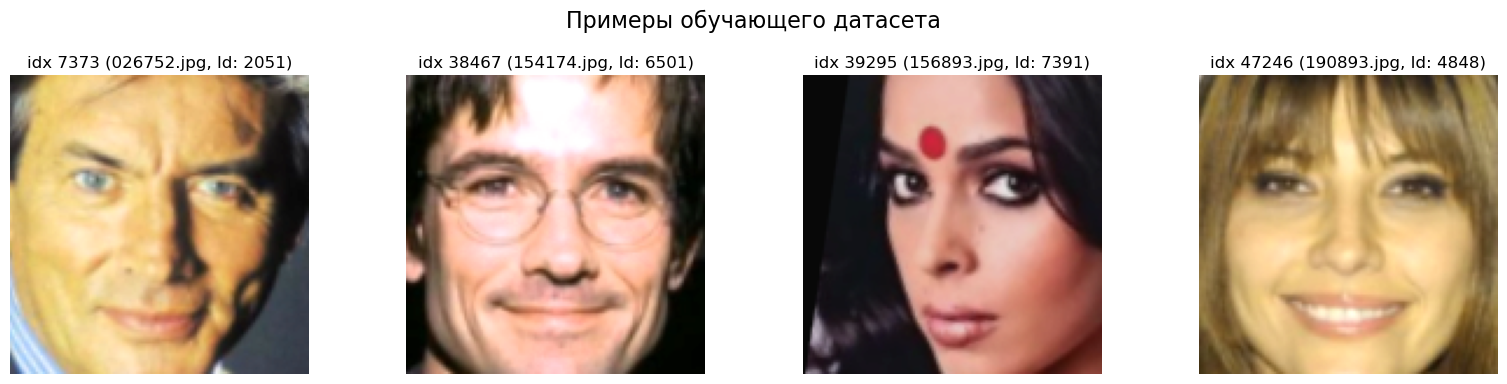

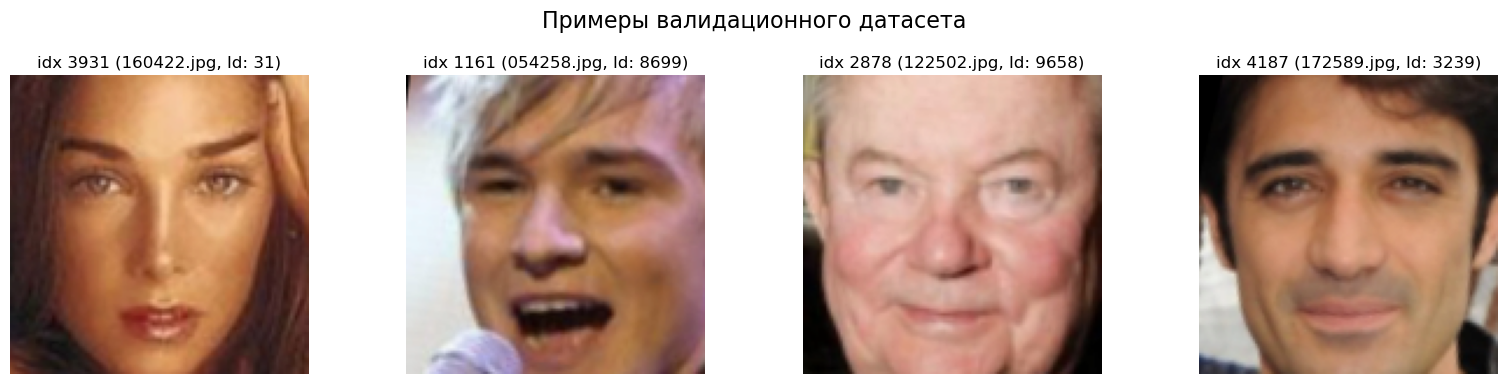

In [21]:
import matplotlib.pyplot as plt
import random
import numpy as np # Добавлен импорт numpy

def visualize_dataset_item(image_tensor, ax, title="Визуализация элемента датасета"):
    """
    Визуализирует изображение из датасета.
    """

    # Денормализуем изображение для отображения
    mean = torch.tensor(NORMALIZE_MEAN, device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor(NORMALIZE_STD, device=image_tensor.device).view(3, 1, 1)
    image_denormalized = image_tensor * std + mean
    image_display = image_denormalized.cpu().permute(1, 2, 0).numpy()

    # Обрезаем значения до [0, 1] для корректного отображения изображения
    image_display = np.clip(image_display, 0, 1)

    ax.imshow(image_display)
    ax.set_title(title)
    ax.axis('off')

def visualize_multiple_dataset_items(dataset, num_items=4, title="Визуализация элементов датасета", items=[]):
    """
    Визуализирует несколько изображений из датасета в сетке.
    """
    fig, axes = plt.subplots(1, num_items, figsize=(4 * num_items, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_items):
        idx = random.randint(0, len(dataset) - 1) if len(items) <= i else items[i]
        image, identity_label = dataset[idx] # Исправлено: получаем identity вместо keypoints
        image_id = dataset.files[idx] # Get image_id here
        visualize_dataset_item(image, axes[i], title=f"idx {idx} ({image_id}, Id: {identity_label})") # Исправлено: убрана передача keypoints, добавлен identity в заголовок

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Визуализируем 4 случайных элемента из обучающего датасета
visualize_multiple_dataset_items(train_dataset, num_items=4, title="Примеры обучающего датасета")

# Визуализируем 4 случайных элемента из валидационного датасета
visualize_multiple_dataset_items(val_dataset, num_items=4, title="Примеры валидационного датасета")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        # Нормализуем признаки и веса
        # input: N x in_features
        # weight: out_features x in_features
        # cosine: N x out_features
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))

        if label is None: # Режим инференса: возвращаем масштабированную косинусную схожесть
            return self.s * cosine

        # Режим обучения с отступом
        # Ограничиваем косинус, чтобы избежать численной нестабильности для arccos
        cosine = cosine.clamp(-1.0 + 1e-7, 1.0 - 1e-7)

        # Вычисление углового отступа
        theta = torch.acos(cosine)

        # Применяем аддитивный угловой отступ в угловом пространстве
        phi = torch.cos(theta + self.m)

        # Создаем one-hot маску для целевых классов
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # Заменяем косинус для целевого класса на phi
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)

        # Масштабируем логиты
        output *= self.s
        return output

class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes, backbone_name='resnet50', loss_type='ce', s=64.0, m=0.50):
        super(FaceRecognitionModel, self).__init__()
        self.loss_type = loss_type
        self.num_classes = num_classes

        # Загружаем бэкбон ResNet-50 с предобученными весами ImageNet
        if backbone_name == 'resnet50':
            self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            # Удаляем оригинальный полносвязный слой для получения признаков напрямую
            in_features_backbone = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError(f"Бэкбон {backbone_name} не поддерживается.")

        # Инициализируем "голову" (head) в зависимости от типа функции потерь
        if self.loss_type == 'ce':
            self.head = nn.Linear(in_features_backbone, num_classes)
        elif self.loss_type == 'arcface':
            self.head = ArcFace(in_features_backbone, num_classes, s=s, m=m)
        else:
            raise ValueError(f"Тип функции потерь {loss_type} не поддерживается. Выберите 'ce' или 'arcface'.")

    def forward(self, x, labels=None, return_features_only=False):
        # Убеждаемся, что входные данные имеют тип float для бэкбона
        x = x.float()
        features = self.backbone(x)

        # Если нужно вернуть только признаки, делаем это
        if return_features_only:
            return features

        # Передаем признаки и метки (если ArcFace) в "голову"
        if self.loss_type == 'arcface':
            # "Голова" ArcFace обрабатывает случай, если метки отсутствуют (инференс против обучения)
            logits = self.head(features, labels)
        else: # Тип функции потерь 'ce'
            logits = self.head(features)

        return logits


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import numpy as np
from collections import defaultdict
import random

def calculate_face_recognition_metrics(model, val_dataloader, device):
    """
    Рассчитывает метрики распознавания лиц (EER, ROC AUC) на валидационном датасете.

    Args:
        model (nn.Module): Модель распознавания лиц.
        val_dataloader (DataLoader): DataLoader для валидационного датасета.
        device (torch.device): Устройство (CPU или GPU) для выполнения вычислений.

    Returns:
        tuple: Кортеж из (EER, ROC AUC). Возвращает (1.0, 0.0) в случае недостатка данных.
    """
    model.eval()  # Переводим модель в режим оценки
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            # Извлекаем эмбеддинги, используя return_features_only=True
            embeddings = model(images, return_features_only=True)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())

    if not all_embeddings: # Если эмбеддинги не были извлечены
        print("No embeddings extracted. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Группируем эмбеддинги по identity
    embeddings_by_identity = defaultdict(list)
    for emb, label in zip(all_embeddings, all_labels):
        embeddings_by_identity[label.item()].append(emb)

    # Для расчета метрик нам нужно как минимум 2 уникальных identity
    # и как минимум 2 изображения для каждой identity для формирования позитивных пар.
    # Также для негативных пар нужно минимум 2 identity
    unique_identities = list(embeddings_by_identity.keys())

    if len(unique_identities) < 2 or any(len(v) < 2 for v in embeddings_by_identity.values()):
        print("Not enough unique identities or images per identity to form pairs. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    positive_similarities = []
    negative_similarities = []

    # Генерация позитивных и негативных пар
    # Будем генерировать пары таким образом, чтобы количество позитивных и негативных пар было примерно равным
    # и чтобы избежать слишком большого количества пар для больших датасетов
    num_max_pairs_per_identity = 100 # Ограничение на количество пар, чтобы избежать слишком долгих вычислений

    for i, identity_i in enumerate(unique_identities):
        embs_i = embeddings_by_identity[identity_i]

        # Генерируем позитивные пары для identity_i
        if len(embs_i) >= 2:
            for k in range(min(len(embs_i) - 1, num_max_pairs_per_identity // 2)):
                idx1, idx2 = random.sample(range(len(embs_i)), 2)
                sim = F.cosine_similarity(embs_i[idx1].unsqueeze(0), embs_i[idx2].unsqueeze(0))
                positive_similarities.append(sim.item())

        # Генерируем негативные пары для identity_i
        if len(unique_identities) > 1:
            # Выбираем случайную другую identity
            other_identities = [id for id in unique_identities if id != identity_i]
            for k in range(min(len(embs_i), num_max_pairs_per_identity // 2)):
                # Выбираем эмбеддинг из текущей identity
                emb1 = random.choice(embs_i)

                # Выбираем случайную другую identity и один ее эмбеддинг
                identity_j = random.choice(other_identities)
                embs_j = embeddings_by_identity[identity_j]
                emb2 = random.choice(embs_j)

                sim = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
                negative_similarities.append(sim.item())

    if not positive_similarities or not negative_similarities:
        print("Could not form enough positive or negative pairs. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    # Объединяем все сходства и их истинные метки
    similarities = np.array(positive_similarities + negative_similarities)
    # 1 для позитивных пар, 0 для негативных
    labels = np.array([1] * len(positive_similarities) + [0] * len(negative_similarities))

    # Расчет ROC-кривой и AUC
    fpr, tpr, thresholds = roc_curve(labels, similarities)
    roc_auc = auc(fpr, tpr)

    # Расчет EER
    fnr = 1 - tpr
    eer_threshold_idx = np.argmin(np.abs(fpr - fnr))
    eer = fpr[eer_threshold_idx]

    return eer, roc_auc


# Task
Implement a function `calculate_face_recognition_metrics` that takes a face recognition model, a validation DataLoader, and a device as input. This function should:
1. Extract embeddings for all images in the validation DataLoader using the provided model.
2. Generate positive pairs (images of the same person) and negative pairs (images of different people) from the extracted embeddings and their corresponding identity labels.
3. Calculate the cosine similarity for each generated pair.
4. Compute the Equal Error Rate (EER) and ROC AUC score from these similarities and their true labels (1 for positive, 0 for negative).
5. Return the calculated EER and ROC AUC scores.

The function should handle cases where there might not be enough unique identities or images per identity to form pairs, returning default or informative values. Ensure `torch.nn.functional` is used for cosine similarity and `sklearn.metrics` for EER and ROC AUC.

## implement_metric_calculation

### Subtask:
Implement a function to calculate face recognition metrics (EER, ROC-AUC) on a validation dataset. This involves extracting embeddings, generating positive and negative pairs, calculating cosine similarity, and using `sklearn.metrics` to compute the final scores.


## Summary:

### Data Analysis Key Findings
*   A function `calculate_face_recognition_metrics` was successfully implemented to evaluate face recognition model performance.
*   The implemented function extracts embeddings for all images in a validation dataset, then intelligently generates positive and negative pairs based on identity labels.
*   It computes the cosine similarity for each generated pair, providing a measure of likeness between faces.
*   The function calculates two critical face recognition performance metrics: the Equal Error Rate (EER) and the ROC AUC score, leveraging `sklearn.metrics` for accuracy.
*   Robustness was ensured by incorporating handling for scenarios where insufficient unique identities or images per identity are available to form pairs, returning appropriate default or informative values.

### Insights or Next Steps
*   This robust metric calculation function enables quantitative assessment and comparison of face recognition models, which is essential for model development and improvement.
*   The next step involves integrating this `calculate_face_recognition_metrics` function into the training and validation pipeline to systematically monitor and track model performance during the development cycle.
